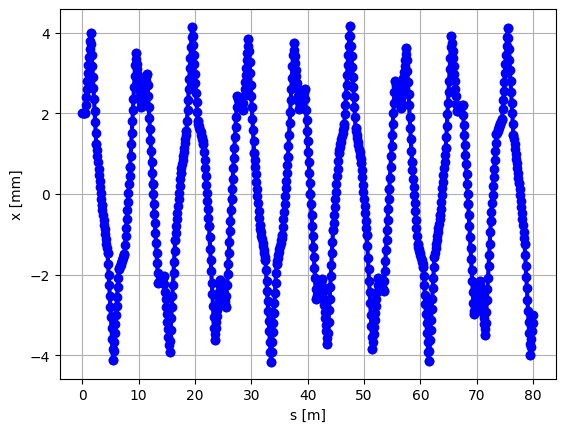

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Function to return the matrix of a L-long drift
def D(L):
    '''Returns the matrix of a L-long drift'''
    return np.array([[1, L], [0, 1]])

# Function to return the matrix of a quadrupole with focal length f
def Q(f):
    '''Returns the matrix of a quadrupole with focal length f'''
    return np.array([[1, 0], [-1/f, 1]])

# Example of multiplying matrices for a sequence of elements
M = D(1.2) @ Q(3) @ D(2.5)

# Function to get the equivalent single element of a beamline
def getEquivalentElement(beamline):
    '''Returns the equivalent single element of a beamline.'''
    equivalentElement = np.eye(2)
    for element in beamline[::-1]:
        equivalentElement = equivalentElement @ element
    return equivalentElement

# Function to transport particles through the beamline
def transportParticles(x0, beamline):
    '''Returns the list of positions in the beamline starting from x0.'''
    x = [x0]
    for element in beamline:
        x.append(element @ x[-1])
    return np.array(x).transpose()[0]

# Function to return the list of a L-long drift as a dictionary
def D(L):
    '''Returns the list of a L-long drift'''
    return [{'matrix': np.array([[1, L], [0, 1]]), 'length': L}]

# Function to return the list of a quadrupole with focal length f as a dictionary
def Q(f):
    '''Returns the list of a quadrupole with focal length f'''
    return [{'matrix': np.array([[1, 0], [-1/f, 1]]), 'length': 0}]

# Redefine getEquivalentElement function to handle dictionary elements
def getEquivalentElement(beamline):
    '''Returns the equivalent single element of a beamline'''
    equivalentElement = np.eye(beamline[0]['matrix'].shape[0])
    length = 0
    for element in beamline[::-1]:
        equivalentElement = equivalentElement @ element['matrix']
        length += element['length']
    return {'matrix': equivalentElement, 'length': length}

# Redefine transportParticles function to handle dictionary elements
def transportParticles(x0, beamline):
    '''Track the particle(s) x0 along the beamline'''
    coords = [x0]
    s = [0]
    for element in beamline:
        coords.append(element['matrix'] @ coords[-1])
        s.append(s[-1] + element['length'])
    coords = np.array(coords).transpose()
    return {'x': coords[:, 0, :], 'px': coords[:, 1, :], 's': np.array(s), 'coords': coords}

# Define and combine beamlines
mybeamline_1 = D(2.5) + Q(3) + D(1.2)
mybeamline_2 = D(2) + Q(-1)
mybeamline_3 = (mybeamline_1 * 2 + mybeamline_2) * 3

# Example of mapping initial coordinates along the beamline and plotting
f = 1
L = 1/10
beamline = 5 * D(L) + Q(-f) + 10 * D(L) + Q(0.84 * f) + 5 * D(L)
x_start = [[0.002], [0]]

output = transportParticles(x_start, beamline * 40)

plt.plot(output['s'], output['x'][0] * 1000, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.show()

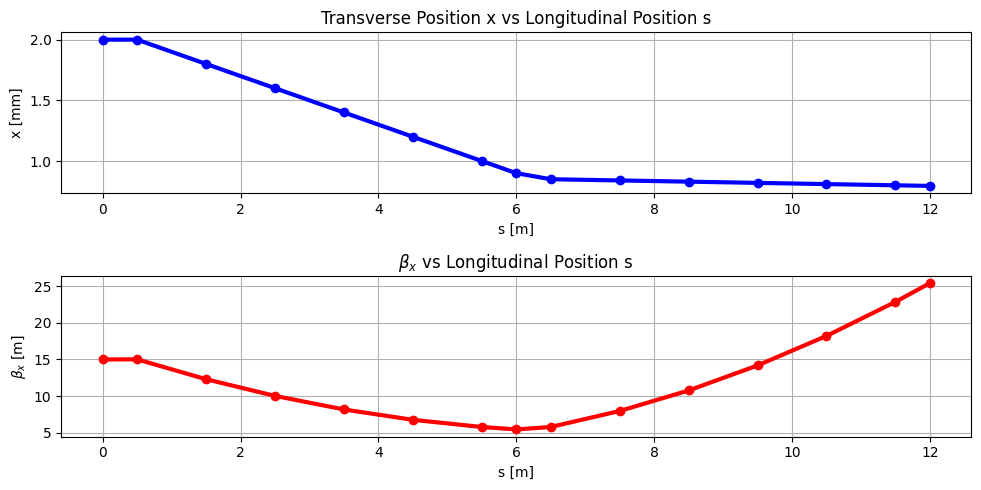

Equivalent matrix of the beamline:
[[ 0.3975 18.6   ]
 [-0.045   0.3975]]


In [65]:


# Function to return the matrix of a L-long drift
def D(L):
    '''Returns the list of a L-long drift'''
    return [{'matrix': np.array([[1, L], [0, 1]]), 'length': L}]

# Function to return the matrix of a quadrupole with focal length f
def Q(K1, L):
    '''Returns the list of a quadrupole with focal length f'''
    return [{'matrix': np.array([[1, L], [-K1 * L, 1]]), 'length': L}]

# Function to get the equivalent single element of a beamline
def getEquivalentElement(beamline):
    '''Returns the equivalent single element of a beamline'''
    equivalentElement = np.eye(beamline[0]['matrix'].shape[0])
    length = 0
    for element in beamline[::-1]:
        equivalentElement = equivalentElement @ element['matrix']
        length += element['length']
    return {'matrix': equivalentElement, 'length': length}

# Function to transport particles through the beamline and calculate Twiss parameters
def transportParticles(x0, beamline):
    '''Track the particle(s) x0 along the beamline'''
    coords = [x0]
    s = [0]
    beta_x = [15.0]  # Initial value for beta_x (assumed)
    alpha_x = [0.0]  # Initial value for alpha_x (assumed)
    gamma_x = [(1 + alpha_x[0]**2) / beta_x[0]]  # Initial value for gamma_x

    for element in beamline:
        coords.append(element['matrix'] @ coords[-1])
        s.append(s[-1] + element['length'])

        # Update Twiss parameters
        m = element['matrix']
        new_beta_x = m[0, 0]**2 * beta_x[-1] - 2 * m[0, 0] * m[0, 1] * alpha_x[-1] + m[0, 1]**2 * gamma_x[-1]
        new_alpha_x = -m[0, 0] * m[1, 0] * beta_x[-1] + (m[0, 0] * m[1, 1] + m[0, 1] * m[1, 0]) * alpha_x[-1] - m[0, 1] * m[1, 1] * gamma_x[-1]
        new_gamma_x = m[1, 0]**2 * beta_x[-1] - 2 * m[1, 0] * m[1, 1] * alpha_x[-1] + m[1, 1]**2 * gamma_x[-1]
        beta_x.append(new_beta_x)
        alpha_x.append(new_alpha_x)
        gamma_x.append(new_gamma_x)

    coords = np.array(coords).transpose()
    return {'x': coords[:, 0, :], 'px': coords[:, 1, :], 's': np.array(s), 'coords': coords, 'beta_x': np.array(beta_x)}

# Define the beamline according to the MAD-X FODO structure
QF = Q(0.2, 0.5)
QD = Q(-0.2, 0.5)
D1 = D(1.0)

# Combining the elements to match the FODO structure
beamline = QF + D1 * 5 + QD + QD + D1 * 5 + QF

# Initial particle position
x_start = [[0.02], [0]]

# Transport the particle through the beamline
output = transportParticles(x_start, beamline)

# Plotting the transverse position x as a function of the longitudinal position s
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(output['s'], output['x'][0] * 1000, 'o-b', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel('x [mm]')
plt.title('Transverse Position x vs Longitudinal Position s')

# Plotting the beta function beta_x as a function of the longitudinal position s
plt.subplot(2, 1, 2)
plt.plot(output['s'], output['beta_x'], 'o-r', lw=3)
plt.grid(True)
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_x$ [m]')
plt.title(r'$\beta_x$ vs Longitudinal Position s')

plt.tight_layout()
plt.show()

# Output TWISS parameters for visualization
print("Equivalent matrix of the beamline:")
print(getEquivalentElement(beamline)['matrix'])
